# Upwelling analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
from cmocean import cm as cmocean
from matplotlib import cm, colors
from scipy.interpolate import griddata
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools
import NEMO_upwelling_postprocessing as ps

%matplotlib inline

In [81]:
# Increase plot font size
plt.rcParams['font.size'] = 14

***

## Load variables

In [3]:
# ------- Load variables -----------

# NetCDF objects
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

# Upwelling events
with open('parameters.yaml') as f: _, _, events = yaml.safe_load_all(f)

# Idealized parameters
params = {
    'u_wind': [5, 10, 15],
    'h_s': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
    'N': np.arange(0.01, 0.026, 0.0025),
}

# Constants
const = {
    'g': 9.81, 'f': 1.11e-4, 'N': 0.01, 'h_s': 10, 'H': 50, 'L_r': 2e4, 't': 86400,
    'rho_0': 1025, 'rho_s': 1020, 'rho_air': 1.23, 'C_d': 1e-3,
}

## Processing

***

In [4]:
# ------- Results postprocessing code -----------
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry.values, grid_HRDPS, const)
runs_idealized = ps.load_idealized(params, sections, mask, const)
runs_hindcast = ps.load_hindcast(events, HRDPS, sections, mask, const, load_wind=True)
runs_idealized = ps.calc_predictions(runs_idealized, const)
runs_hindcast = ps.calc_predictions(runs_hindcast, const)

/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:65: RuntimeWarning: invalid value encountered in greater
  index = np.array([bathy[y, x] for y, x in zip(j_s, i_s)]) > const['H']


***

## Results

### Choboter predictions versus model results

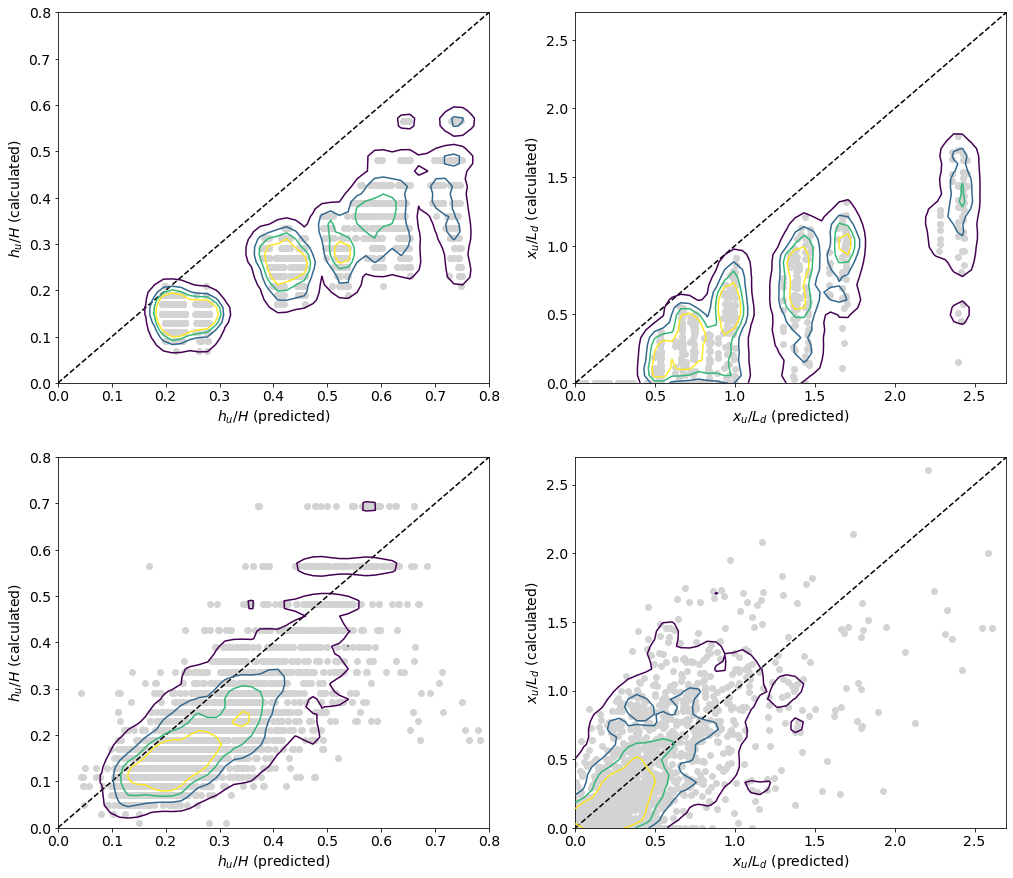

In [82]:
# ------- Choboter predictions -----------
fig, axs = plt.subplots(2, 2, figsize=(17, 15))

# KDE parameters
n, lim, levels, bandwidth = 50, 1, np.array([1, 4, 7, 10]), 0.02

# Loop through rows
for row, runs in zip(axs, [runs_idealized, runs_hindcast]):

    # Loop through columns
    for ax, key, normkey, lim in zip(row, ['h_u', 'x_u'], ['H', 'L_d'], [0.8, 2.7]):

        # Plot data
        norm = const[normkey] if normkey == 'H' else runs[normkey]
        x, y = runs[key+'_pred']/norm, runs[key]/norm
        ax.plot(x, y, 'o', color='lightgray')

        # Plot KDE
        index = (runs[key] > 0) & ~np.isnan(runs[key+'_pred'])
        grid = np.linspace(0, lim, n)
        xy_data = np.vstack([x[index], y[index]]).T
        xy_grid = np.vstack([dim.ravel() for dim in np.meshgrid(grid, grid)]).T
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth*lim)
        z = np.exp(kde.fit(xy_data).score_samples(xy_grid)).reshape((n, n))
        ax.contour(grid, grid, z, levels=levels/lim**2, zorder=10)

        # Formatting
        ax.plot([0, lim], [0, lim], 'k--')
        ax.set_xlim([0, lim])
        ax.set_ylim([0, lim])
        ax.set_xlabel(f'${key}/{normkey}$ (predicted)')
        ax.set_ylabel(f'${key}/{normkey}$ (calculated)')

***

### Choboter predictions in space

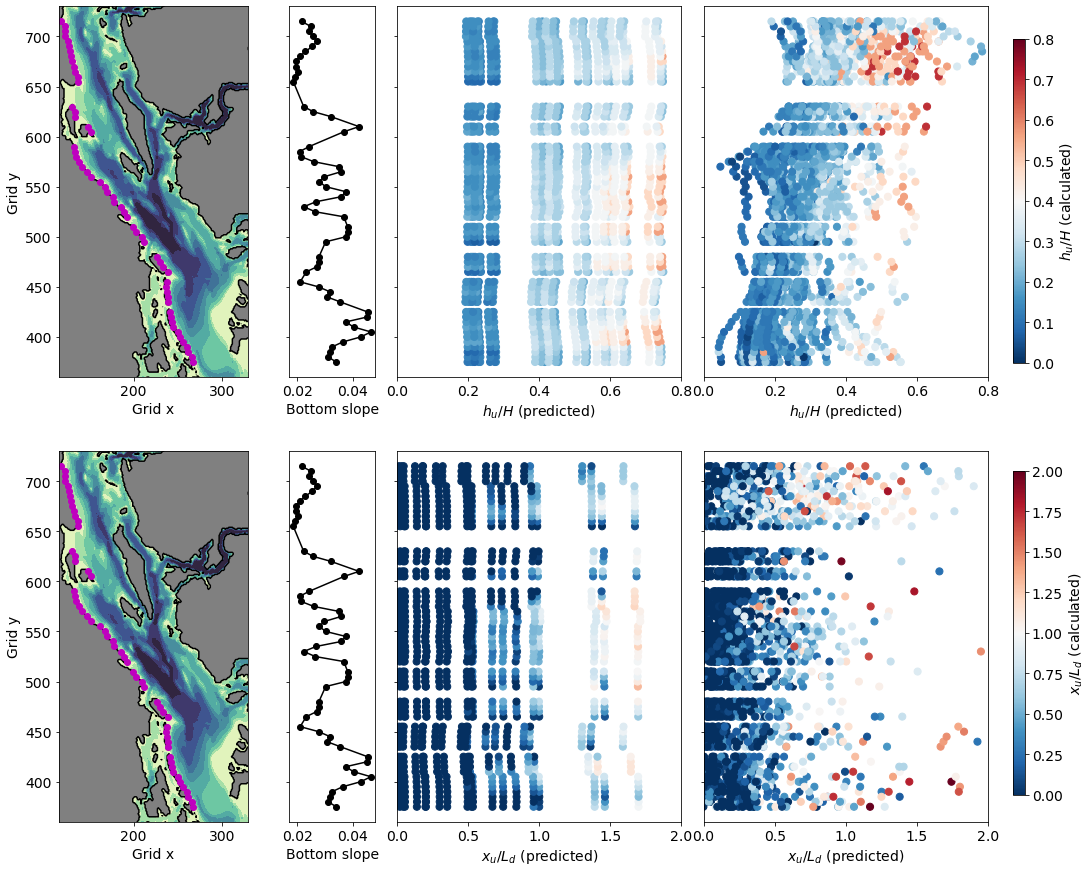

In [84]:
# ------- Choboter predictions in space -----------
fig, axs = plt.subplots(2, 4, figsize=(17, 15), gridspec_kw={'width_ratios': [0.8, 0.3, 1, 1], 'wspace': 0.1})

# Loop through rows
for row, key, normkey, lim, ypos in zip(axs, ['h_u', 'x_u'], ['H', 'L_d'], [0.8, 2], [0.55, 0.15]):

    # Plot map and bathymetry
    row[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
    row[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    row[0].contourf(bathy.Bathymetry, levels=range(0, 500, 50), cmap=cmocean.deep)
    row[0].plot(*sections['ji'][::-1], 'mo')
    row[0].set_xlim([115, 330])
    row[0].set_ylim([360, 730])
    row[0].set_xlabel('Grid x')
    row[0].set_ylabel('Grid y')
    viz_tools.set_aspect(row[0])

    # Plot bottom slope
    row[1].plot(sections['slope'], sections['ji'][0], 'ko-')
    row[1].set_ylim([0, 0.05])
    row[1].set_ylim([360, 730])
    row[1].set_xlabel('Bottom slope')
    row[1].yaxis.set_ticklabels('')

    # Plot upwelling diagnostics
    for ax, runs in zip(row[2:], [runs_idealized, runs_hindcast]):
        norm = const[normkey] if normkey == 'H' else runs[normkey]
        c = ax.scatter(runs[key + '_pred']/norm, runs['j'], s=50, c=runs[key]/norm, vmin=0, vmax=lim, cmap='RdBu_r')
        ax.set_xlim([0, lim])
        ax.set_ylim([360, 730])
        ax.set_xlabel(f'${key}/{normkey}$ (predicted)')
        ax.yaxis.set_ticklabels('')

    # Add colorbar
    cax = fig.add_axes([0.92, ypos, 0.01, 0.3])
    fig.colorbar(c, cax=cax, label=f'${key}/{normkey}$ (calculated)')

***

### Choboter predictions slope dependence

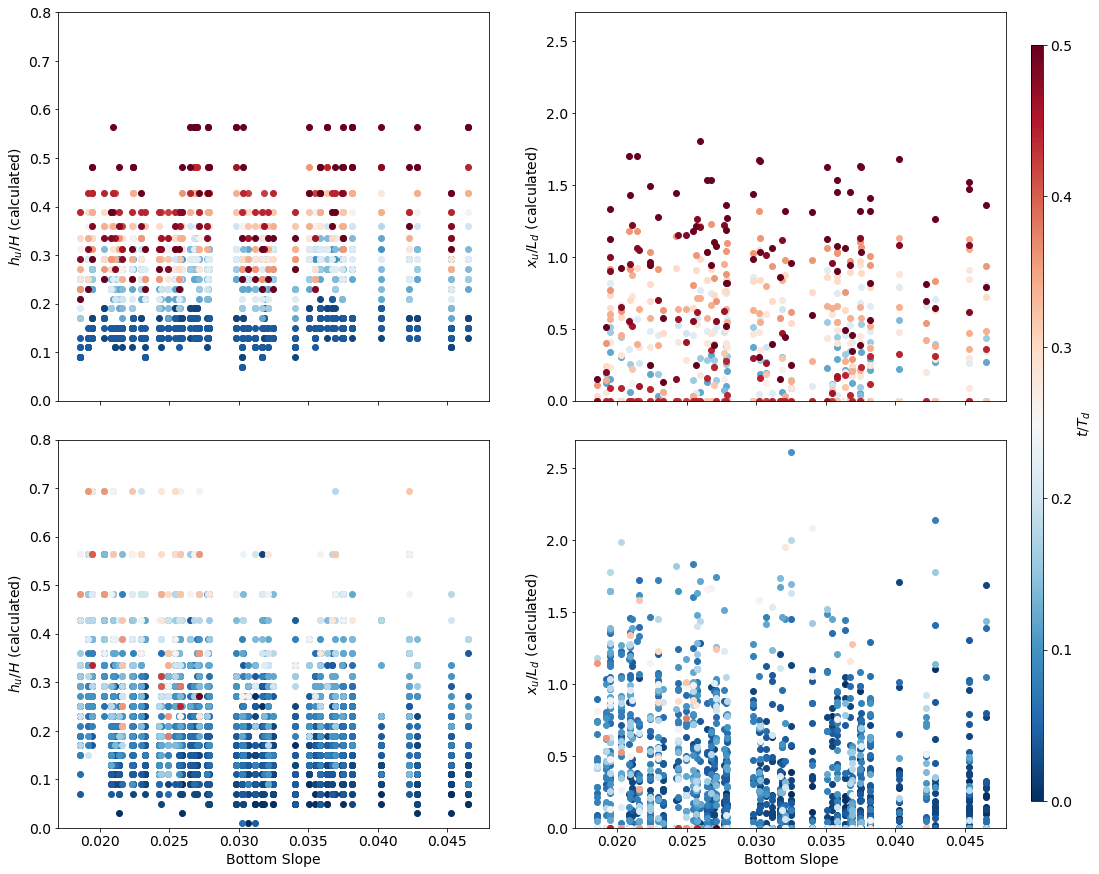

In [86]:
# ------- Choboter predictions slope dependence -----------
fig, axs = plt.subplots(2, 2, figsize=(17, 15), gridspec_kw={'hspace': 0.1})
cmap = plt.get_cmap('RdBu_r')

# Loop through rows
for n, row, runs in zip(range(2), axs, [runs_idealized, runs_hindcast]):

    # Loop through columns
    for ax, key, normkey, lim in zip(row, ['h_u', 'x_u'], ['H', 'L_d'], [0.8, 2.7]):

        # Plot data
        norm = const[normkey] if normkey == 'H' else runs[normkey]
        for t in np.arange(0, 0.501, 0.02): 
            index = (const['t']/runs['T_d'] > t) & (const['t']/runs['T_d'] < t + 0.02)
            ax.plot(runs['slope'][index], (runs[key]/norm)[index], 'o', color=cmap(2*t))

        # Formatting
        ax.set_xlim([0.017, 0.048])
        ax.set_ylim([0, lim])
        ax.set_ylabel(f'${key}/{normkey}$ (calculated)')
        if n == 1: ax.set_xlabel('Bottom Slope')
        else: ax.xaxis.set_ticklabels('')

cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
c = cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=0.5), cmap=cmap)
fig.colorbar(c, cax=cax, label='$t/T_d$')
plt.show()

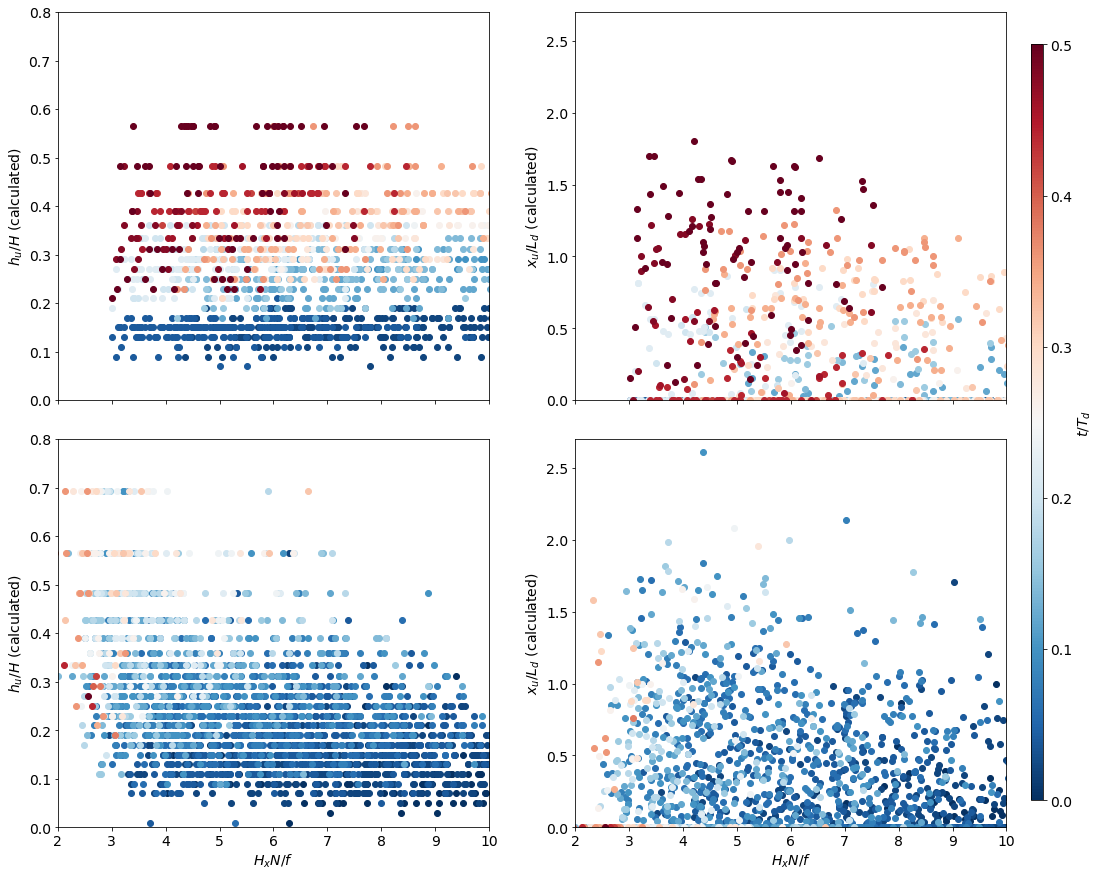

In [89]:
# ------- Choboter predictions slope dependence -----------
fig, axs = plt.subplots(2, 2, figsize=(17, 15), gridspec_kw={'hspace': 0.1})
cmap = plt.get_cmap('RdBu_r')

# Loop through rows
for n, row, runs in zip(range(2), axs, [runs_idealized, runs_hindcast]):

    # Loop through columns
    for ax, key, normkey, lim in zip(row, ['h_u', 'x_u'], ['H', 'L_d'], [0.8, 2.7]):

        # Plot data
        norm = const[normkey] if normkey == 'H' else runs[normkey]
        for t in np.arange(0, 0.501, 0.02): 
            index = (const['t']/runs['T_d'] > t) & (const['t']/runs['T_d'] < t + 0.02)
            ax.plot(runs['S'][index], (runs[key]/norm)[index], 'o', color=cmap(2*t))

        # Formatting
        ax.set_xlim([2, 10])
        ax.set_ylim([0, lim])
        ax.set_ylabel(f'${key}/{normkey}$ (calculated)')
        if n == 1: ax.set_xlabel('$H_xN/f$')
        else: ax.xaxis.set_ticklabels('')

cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
c = cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=0.5), cmap=cmap)
fig.colorbar(c, cax=cax, label='$t/T_d$')
plt.show()

***

### Choboter predictions in parameter space

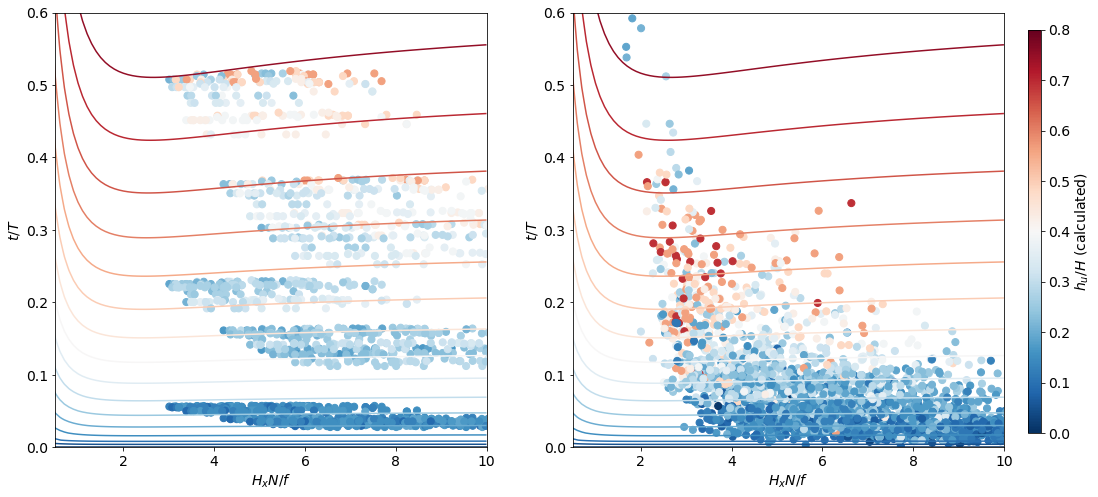

In [87]:
# ------- Choboter predictions in parameter space -----------
fig, axs = plt.subplots(1, 2, figsize=(17, 8))
cmap = plt.get_cmap('RdBu_r')

# Build predicted contours
S, tT = np.meshgrid(np.arange(0.1, 10.1, 0.1), np.arange(0, 1.01, 0.01))                                                                                                 
exp = 1 - np.exp(-2 * np.arctan(S) * tT)
h_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S))

# Plot run results
for ax, runs in zip(axs, [runs_idealized, runs_hindcast]):
    ax.contour(S, tT, h_u, levels=np.arange(0, 0.81, 0.05), cmap=cmap)
    c = ax.scatter(runs['S'], const['t']/runs['T_d'], s=50, c=runs['h_u']/const['H'], cmap=cmap, vmin=0, vmax=0.8)
    ax.set_xlim([0.5, 10])
    ax.set_ylim([0, 0.6])
    ax.set_xlabel('$H_xN/f$')
    ax.set_ylabel('$t/T$')

# Add colorbar
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$h_u/H$ (calculated)')
plt.show()